## Data importing

In [1]:
# import utilities to retrieve the dataset from Kaggle

from google.colab import files
! pip install -q kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download uraninjo/augmented-alzheimer-mri-dataset
!unzip /content/augmented-alzheimer-mri-dataset.zip

'\nfrom google.colab import files\n! pip install -q kaggle\nfiles.upload()\n! mkdir ~/.kaggle\n! cp kaggle.json ~/.kaggle/\n! chmod 600 ~/.kaggle/kaggle.json\n! kaggle datasets download uraninjo/augmented-alzheimer-mri-dataset\n!unzip /content/augmented-alzheimer-mri-dataset.zip'

## Imports

In [2]:
# import the libraries and modules used in the notebook

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, classification_report, ConfusionMatrixDisplay

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
%matplotlib inline

## Data loading/preprocessing

In [3]:
# load the data into train, test and validation

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/AugmentedAlzheimerDataset",
    labels='inferred',
    seed=2023,
    image_size=[176, 208],
    batch_size=16,
)

val_ds, test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/OriginalDataset",
    validation_split=0.2,
    labels='inferred',
    subset="both",
    seed=2023,
    image_size=[176, 208],
    batch_size=16,
)

Found 33984 files belonging to 4 classes.
Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Using 1280 files for validation.


In [4]:
# create the 4 classes and one-hot encode the labels

class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names
test_ds.class_names = class_names

NUM_CLASSES = len(class_names)

def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

## Transfer Learning

In [6]:
# create the "new" ResNet50 model

model_resnet50 = ResNet50(input_shape=(176,208,3), weights='imagenet', include_top=False)

model_resnet50.trainable = False

x = Flatten()(model_resnet50.output)

prediction = Dense(NUM_CLASSES, activation = "softmax")(x)

model_resnet50 = Model(inputs=model_resnet50.input, outputs=prediction)

model_resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 208, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 182, 214, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 88, 104, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 88, 104, 64)  256         ['conv1_conv[0][0]']         

In [7]:
# compile and train this model

model_resnet50.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(), metrics=[keras.metrics.AUC(name='auc'),'acc'])

resnet_history = model_resnet50.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
2124/2124 [==============================] - 118s 52ms/step - loss: 3.6124 - auc: 0.8460 - acc: 0.7069 - val_loss: 0.9181 - val_auc: 0.9540 - val_acc: 0.8793
Epoch 2/20
2124/2124 [==============================] - 108s 51ms/step - loss: 1.9926 - auc: 0.9203 - acc: 0.8379 - val_loss: 2.2202 - val_auc: 0.9079 - val_acc: 0.8182
Epoch 3/20
2124/2124 [==============================] - 108s 51ms/step - loss: 1.5779 - auc: 0.9418 - acc: 0.8799 - val_loss: 2.3846 - val_auc: 0.9142 - val_acc: 0.8346
Epoch 4/20
2124/2124 [==============================] - 115s 54ms/step - loss: 1.2943 - auc: 0.9535 - acc: 0.9047 - val_loss: 1.5098 - val_auc: 0.9454 - val_acc: 0.8936
Epoch 5/20
2124/2124 [==============================] - 107s 50ms/step - loss: 1.1727 - auc: 0.9592 - acc: 0.9170 - val_loss: 1.4540 - val_auc: 0.9465 - val_acc: 0.8947
Epoch 6/20
2124/2124 [==============================] - 114s 54ms/step - loss: 0.8529 - auc: 0.9699 - acc: 0.9372 - val_loss: 2.2894 - val_auc: 0.9301 - va

## My CNN

In [8]:
# create all the layers in the CNN

model_cnn = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(176,208,3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(rate=0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax')
])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 174, 206, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 172, 204, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 86, 102, 64)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 86, 102, 64)       0         
                                                                 
 flatten_1 (Flatten)         (None, 561408)            0         
                                                                 
 dense_1 (Dense)             (None, 128)               71860352  
                                                        

In [9]:
# compile and train this model

model_cnn.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(), metrics=[keras.metrics.AUC(name='auc'),'acc'])

cnn_history = model_cnn.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
2124/2124 [==============================] - 149s 68ms/step - loss: 15.2334 - auc: 0.6449 - acc: 0.3588 - val_loss: 1.1065 - val_auc: 0.7137 - val_acc: 0.3881
Epoch 2/20
2124/2124 [==============================] - 146s 69ms/step - loss: 1.1523 - auc: 0.7312 - acc: 0.4369 - val_loss: 1.0388 - val_auc: 0.7839 - val_acc: 0.4908
Epoch 3/20
2124/2124 [==============================] - 146s 69ms/step - loss: 1.0483 - auc: 0.7891 - acc: 0.5058 - val_loss: 1.1420 - val_auc: 0.7883 - val_acc: 0.4832
Epoch 4/20
2124/2124 [==============================] - 145s 68ms/step - loss: 0.9650 - auc: 0.8276 - acc: 0.5592 - val_loss: 0.9081 - val_auc: 0.8725 - val_acc: 0.6268
Epoch 5/20
2124/2124 [==============================] - 146s 69ms/step - loss: 0.7879 - auc: 0.8895 - acc: 0.6513 - val_loss: 0.5782 - val_auc: 0.9485 - val_acc: 0.7889
Epoch 6/20
2124/2124 [==============================] - 146s 69ms/step - loss: 0.7135 - auc: 0.9120 - acc: 0.6937 - val_loss: 0.4918 - val_auc: 0.9676 - v

## Training curves

In [10]:
# function to plot history for metrics

def plot_history(history, modelName):
  metrics = list(history.history.keys())
  for metric in metrics[:int(len(metrics)/2)]:
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.title(modelName + ' model ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

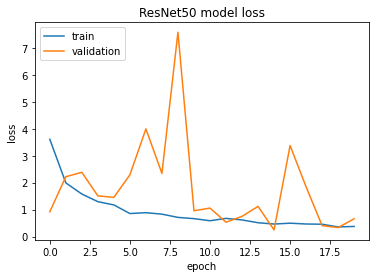

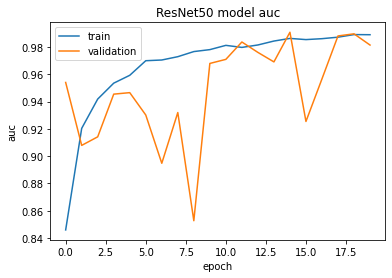

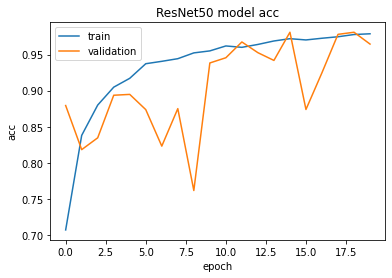

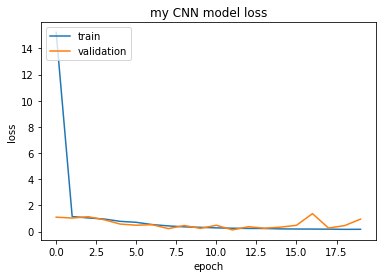

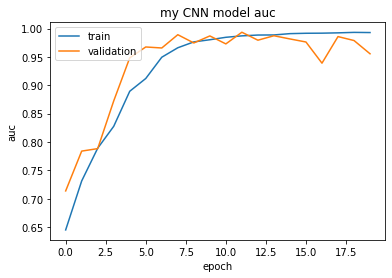

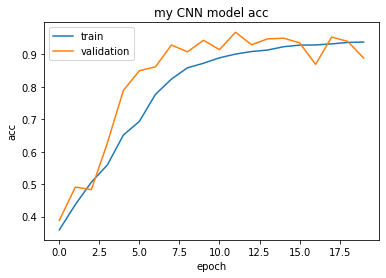

In [11]:
# plot the learning curves of the models

plot_history(resnet_history, "ResNet50")
plot_history(cnn_history, "my CNN")

## Evaluation

In [12]:
# evaluate the models

resnet_test_loss, resnet_test_auc, resnet_test_acc = model_resnet50.evaluate(test_ds)
cnn_test_loss, cnn_test_auc, cnn_test_acc = model_cnn.evaluate(test_ds)
print("ResNet50 test :\n loss : ", resnet_test_loss, " - auc : ", resnet_test_auc, " - accuracy : ", resnet_test_acc)
print("My CNN test :\n loss : ", cnn_test_loss, " - auc : ", cnn_test_auc, " - accuracy : ", cnn_test_acc)

80/80 [==============================] - 1s 14ms/step - loss: 0.9624 - auc: 0.9560 - acc: 0.8883
ResNet50 test :
 loss :  1.0313149690628052  - auc :  0.974608838558197  - accuracy :  0.94921875
My CNN test :
 loss :  0.9624004364013672  - auc :  0.9559577703475952  - accuracy :  0.8882812261581421


In [13]:
# functions to transform the models prediction to interpretable data

def one_hot_to_index(arr):
  new_arr = np.zeros(arr.shape)

  for i in range(arr.shape[0]):
      max_index = np.argmax(arr[i, :])
      new_arr[i, max_index] = 1

  max_indices = np.argmax(new_arr, axis=1)

  return max_indices


def pred_to_one_hot(arr):
  new_arr = np.zeros(arr.shape)

  for i in range(arr.shape[0]):
      max_index = np.argmax(arr[i, :])
      new_arr[i, max_index] = 1

  return new_arr

In [14]:
# compute the kappa score of the models

resnet_pred = one_hot_to_index(pred_to_one_hot(model_resnet50.predict(test_ds)))
cnn_pred = one_hot_to_index(pred_to_one_hot(model_cnn.predict(test_ds)))
y_test = one_hot_to_index(np.concatenate([y for x, y in test_ds], axis=0))

cnn_kappa = cohen_kappa_score(cnn_pred, y_test)
resnet_kappa = cohen_kappa_score(resnet_pred, y_test)

print("ResNet50 Kappa score : ", resnet_kappa)
print("My CNN Kappa score : ", cnn_kappa)

80/80 [==============================] - 1s 13ms/step
ResNet50 Kappa score :  0.9150500306309985
My CNN Kappa score :  0.8116219306487948


In [15]:
# get the classification reports of the models

print("ResNet50 classification report \n" + classification_report(resnet_pred, y_test, target_names=class_names))
print("My CNN classification report \n" + classification_report(cnn_pred, y_test, target_names=class_names))

ResNet50 classification report 
                  precision    recall  f1-score   support

    MildDementia       0.95      1.00      0.98       161
ModerateDementia       1.00      1.00      1.00         9
     NonDementia       1.00      0.91      0.95       689
VeryMildDementia       0.88      1.00      0.94       421

        accuracy                           0.95      1280
       macro avg       0.96      0.98      0.97      1280
    weighted avg       0.95      0.95      0.95      1280

My CNN classification report 
                  precision    recall  f1-score   support

    MildDementia       0.98      0.98      0.98       170
ModerateDementia       1.00      1.00      1.00         9
     NonDementia       1.00      0.82      0.90       759
VeryMildDementia       0.71      0.99      0.83       342

        accuracy                           0.89      1280
       macro avg       0.92      0.95      0.93      1280
    weighted avg       0.92      0.89      0.89      1280

